# C-mean Clustering
Fuzzy c-Means Clustering} (FMC) is a clustering method which, unlike Hard k-Means Clustering, allows a data sample to more or less belong to one or more clusters. In this notebook, we will try to develop a semi-supervised C-mean Clustering.

## Loading the packages

In [1]:
import numpy as np
from cvi import * # fcm
import matplotlib.pyplot as plt
from numpy import genfromtxt
from random import randint
import operator
import math
from sklearn import metrics
import scipy.spatial
import copy
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import _tree
DATASETS = ['datasets/melanomaTest.dat.csv', 'datasets/seeds_dataset.csv'] # http://cibcb.org/data/

PATH_TO_DATASET = DATASETS[1] # Not Given Yet 

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## The dataset
Here we load the dataset and delete randomly some labels to test our implementation of semi-supervised FCM

In [2]:
dataset = genfromtxt(PATH_TO_DATASET, delimiter=';')
    
# save all the labels to calculate the performance of our algorithm
true_labels = copy.copy(dataset[:, -1])
labels_names = np.unique(true_labels)

# remove some labels for test purpose
def removeLabels(dataset, labels_name, percentage):  
    result = copy.copy(dataset)
    # remove percentage of each different labels for test purpose       
    for label in labels_name:
        subArrayIdx = np.where(result[:,-1] == label)[0]
        if len(subArrayIdx):
            idx = np.random.choice(subArrayIdx, int(len(subArrayIdx)*percentage/100), replace=False)
            for i in idx:
                result[i][-1] = 0
            

    return result

dataset = removeLabels(dataset, labels_names, 0)

## FCM algorithm
Here we define a unsupervised implementation of the FCM from ...

In [3]:
def fcm_get_u(x, v, m):
    distances = pairwise_squared_distances(x, v)
    nonzero_distances = np.fmax(distances, np.finfo(np.float64).eps)
    inv_distances = np.reciprocal(nonzero_distances)**(1/(m - 1))
    return inv_distances.T/np.sum(inv_distances, axis=1)

def fcm(x, c, m=2.0, v=None, max_iter=100, error=0.05):
    if v is None: v = x[np.random.randint(x.shape[0], size=c)]
    u = fcm_get_u(x, v, m)
    for iteration in range(max_iter):
        u_old = u
        um = u**m
        v = np.dot(um, x)/np.sum(um, axis=1, keepdims=True)
        u = fcm_get_u(x, v, m)
        if np.linalg.norm(u - u_old) < error: break
    return u, v

## Semi-supervised C-Mean
Here are all the function needed to transform our algorithm to a semi-supervised one

In [4]:
def pairwise_squared_distances(A, B):
    return scipy.spatial.distance.cdist(A, B)**2

def calculate_covariances(x, u, v, m):
    c, n = np.array(u).shape
    d = np.array(v).shape[1]
    
    um = np.array(u)**m

    covariances = np.zeros((c, d, d))

    for i in range(c):
        xv = x - v[i]
        uxv = um[i, :, np.newaxis]*xv
        covariances[i] = np.einsum('ni,nj->ij', uxv, xv)/np.sum(um[i])
    
    return covariances

# Partition Coefficient
def pc(x, u, v, m):
    c, n = np.array(u).shape
    return np.square(np.array(u)).sum()/n

# Fuzzy Hyperbolic Volume
def fhv(x, u, v, m):
    covariances = calculate_covariances(x, u, v, m)
    return sum(np.sqrt(np.linalg.det(cov)) for cov in covariances)

# Xie-Beni Index
def xb(x, u, v, m):
    n = np.array(x).shape[0]
    c = np.array(v).shape[0]

    um = np.array(u)**m
    
    d2 = pairwise_squared_distances(x, v)
    v2 = pairwise_squared_distances(v, v)
    
    v2[v2 == 0.0] = np.inf

    return np.sum(um.T*d2)/(n*np.min(v2))

def checkKnownEntries(dataset, labels, c):
    res = np.zeros((c, len(labels_names)))
    for cluster in range(c) :
        for i in range(len(dataset)):
            if(dataset[i][-1] != 0 and labels[i] == cluster):
                res[cluster][int(dataset[i][-1] - 1)] += 1
    
    for cluster in range(c):
        c_total = res[cluster][0] + res[cluster][1]
        res[cluster][0] /= c_total
        res[cluster][1] /= c_total

    return res

In [5]:
def getClass(dataset, labels, k):
    count_class = np.zeros((k, len(labels_names)))
    newLabels = copy.copy(labels)

    for i in range(len(dataset)):
        if(dataset[i][-1] != 0):
            count_class[labels[i]][int(dataset[i][-1] - 1)] += 1

    for c in range(len(count_class)):  
        indexPredominantClass = np.argmax(count_class[c])
        if np.max(count_class[c]) == 0:
            cl = 0
        else :
            cl = labels_names[indexPredominantClass]
            
        for i in range(len(labels)):
            if labels[i] == c:
                newLabels[i] = cl 
            
    return newLabels
    

In [6]:
def getAccuracy(true_labels, labels):
    same = 0
    for t, p in zip(true_labels, labels):
        if int(t) == int(p):
            same += 1
    return same / len(true_labels) * 100

In [7]:
def getClusters(dataset, membership_mat):
    cluster_labels = list()
    for i in range(len(dataset)):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels

## Rules Extraction
First we create a decision tree based on our predicted results, then we extract rules from this decision tree

In [8]:
def createDecisionTree(dataset):
    #split the dataset
    X = dataset[:,0:-2]
    Y = dataset[:,-1]
    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)
    
    # Create and train the decision tree
    tree = DecisionTreeClassifier(criterion = "entropy", random_state = 100)
    tree.fit(X_train, y_train)
    
    # Test our tree
    y_pred = tree.predict(X_test)
    print ("Tree Accuracy is ", accuracy_score(y_test,y_pred)*100)
    return tree

In [16]:
def extractRules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:{}".format(indent, name, threshold, tree_.value[node]))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {} {}".format(indent, name, threshold, tree_.value[node]))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

## Main Execution 

In [10]:
def clusterize(dataset):
    result_labels = [[]]
    result_mb     = [[]]
    temp_data = copy.deepcopy(dataset)
    c = 2
    done = False
    while(not done and c < math.sqrt(len(dataset))): 
        mb, centers = fcm(dataset[:,:-1], c)
        labels = getClusters(dataset[:,:-1], mb.T )
        
        # First, check supervised values
        # TOFIX : Bordel with cluster indexes, won't work.
        sup_verif = checkKnownEntries(dataset, labels, c)
        cluster_ok = []
        for i in range(c):
            if(sup_verif[i][0] < 0.05 or sup_verif[i][0] > 0.95):
                cluster_ok.append(i)

        if(len(cluster_ok) < c):
            # If no cluster is good enough (with known values) start with more clusters
            c =c + 1
            continue
        else:
            # Check our values aren't just luckily in same clusters using unsup CVI
            #fhv_s = fhv(x = temp_data[:,:-1], v = centers, u = mb, m =2)
            #pc_s  = pc(temp_data[:,:-1], mb, centers, 2)
            #xb_s  = xb(x = temp_data[:,:-1], u = mb, v = centers, m = 2)
            # If values aren't good enough, our know entries were "luckily" grouped
            #if(pc_s < 0.9 or xb_s > 0.1):#fhv_s > 0.1 or 
            #    c = c + 1
            #    continue
            #else:
            done = True
            break
            # Else, we have to keep labeled data and remove it  
            temp_data = [[]]
            for i in range(len(dataset)):
                if(dataset[i][-1] in cluster_ok):
                    result_labels.append(dataset[i].append(labels[i]))
                    result_mb.append(mb[i])
                else:
                    temp_data.append(dataset[i])
                    
            # Keep same number of pixels (equivalent to split remaining clusters in +1)
            continue
            
    return labels, centers, mb

labels, centers, mb = clusterize(dataset)
labels = getClass(dataset, labels, len(centers))
#print("label:", labels, len(labels))
#print("true_label:",true_labels, len(dataset[:,-1]) )
print("number of cluster = ", len(centers))


number of cluster =  14


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


## Results and Analyse

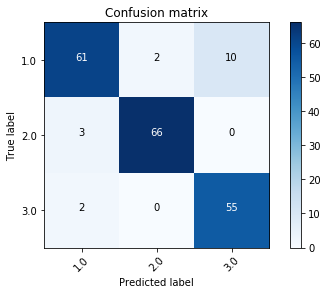

In [11]:
from sklearn.metrics import confusion_matrix
import itertools
conf_mat = metrics.confusion_matrix(labels, true_labels)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels_names))
    plt.xticks(tick_marks, labels_names, rotation=45)
    plt.yticks(tick_marks, labels_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plot_confusion_matrix(conf_mat)

In [12]:
print("Accuracy: ", accuracy_score(labels, true_labels))
precision = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[1][0]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[0][1]))/2
print("Precision: ", precision)
recall = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[1][0]))/2
print("Recall: ", recall)
f1score = 2*(precision*recall)/(precision+recall)
print("F1-Score: ", f1score)
print("Number of clusters: ", len(centers))

Accuracy:  0.914572864321608
Precision:  0.9618566176470589
Recall:  0.9623878536922015
F1-Score:  0.9621221623390998
Number of clusters:  14


In [17]:
dataset[:,-1] = labels

extractRules(createDecisionTree(dataset), ['Area', 'Perimeter', 'Compactness', 'Length of kernel', 'Width of kernel', 'Asymmetry coefficient', 'Length of kernel groove'])


Tree Accuracy is  91.66666666666666
def tree(Area, Perimeter, Compactness, Length of kernel, Width of kernel, Asymmetry coefficient, Length of kernel groove):
  if Perimeter <= 14.870000839233398:[[55. 47. 37.]]
    if Asymmetry coefficient <= 3.3299999237060547:[[47.  0. 37.]]
      return [[39.  0.  0.]]
    else:  # if Asymmetry coefficient > 3.3299999237060547 [[47.  0. 37.]]
      if Area <= 14.354999542236328:[[ 8.  0. 37.]]
        if Asymmetry coefficient <= 4.168000221252441:[[ 3.  0. 37.]]
          if Area <= 12.414999961853027:[[3. 0. 7.]]
            return [[0. 0. 7.]]
          else:  # if Area > 12.414999961853027 [[3. 0. 7.]]
            return [[3. 0. 0.]]
        else:  # if Asymmetry coefficient > 4.168000221252441 [[ 3.  0. 37.]]
          return [[ 0.  0. 30.]]
      else:  # if Area > 14.354999542236328 [[ 8.  0. 37.]]
        return [[5. 0. 0.]]
  else:  # if Perimeter > 14.870000839233398 [[55. 47. 37.]]
    if Perimeter <= 15.305000305175781:[[ 8. 47.  0.]]
  